# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma than the one provided. You can use stock paths simulated by Heston model. You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

# Outline

**Goal**: (1) Understand the effect of a non-constant volatility on PL distribution of options sold (2) Understand how to hedge against changing volatility

**Note**:
* While there are numerous choices for modeling a non-constant volatility, for the sake of simplicity I have focused on regime switching sigma, where sigma is drawn from a discrete distribution with specified probabilities.
* I have used MC_call_custom_sigma and its helper functions provided in the lecture to implement delta hedging.



In [159]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
sns.set_style('darkgrid')

In [160]:
### Note: Copy pasted from notebooks given for lecture 9
##Sample custom model where sigma is not constant, but sigma is randomly chosen from a discrete distribution

# Function that simulates call option Delta with custom sigma distribution

def MC_call_delta_custom(S0, K, sigma,sigma_probs, t, r, delta_sims = int(250)):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Delta
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    bump = .01*S0

    noise = np.random.normal(0,1,delta_sims)
    
    sampled_sigma = np.random.choice(sigma,p=sigma_probs,size=delta_sims)

    log_returns = (r - .5*sampled_sigma**2)*t + sampled_sigma*np.sqrt(t)*noise

    paths_up = (S0+bump)*np.exp(log_returns)
    paths_down = (S0-bump)*np.exp(log_returns)

    call_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)
    call_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    simulated_deltas = (call_up-call_down)/(2*bump)

    return np.mean(simulated_deltas)




    
def MC_call_delta_custom_array(S, K, sigma, sigma_probs, t, r, delta_sims=250):
    """
    Monte Carlo estimation of Black-Scholes call deltas for an array of spot prices
    with stochastic volatility model (discrete distribution).
    
    Parameters:
    S (np.array): array of spot prices
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    """
    bump = 0.01 * S
    noise = np.random.normal(0, 1, (delta_sims, len(S)))

    sampled_sigma = np.random.choice(sigma, p=sigma_probs, size=(delta_sims, len(S)))
    log_returns = (r - 0.5 * sampled_sigma**2) * t + sampled_sigma * np.sqrt(t) * noise

    paths_up = (S + bump) * np.exp(log_returns)
    paths_down = (S - bump) * np.exp(log_returns)

    call_up = np.maximum(paths_up - K, 0) * np.exp(-r * t)
    call_down = np.maximum(paths_down - K, 0) * np.exp(-r * t)

    deltas = (call_up - call_down) / (2 * bump)
    return np.mean(deltas, axis=0)




def MC_call_custom_sigma(S0, K, sigma, sigma_probs, t, r, mu, n_sims, n_hedges , delta_sims):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    
    Warning:
    This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    """
    
    #Create random noise for n_sims number of paths with n_hedges steps in simulated stock movements
    noise = np.random.normal(0,1, (n_sims,n_hedges))

    dt = t/n_hedges #time interval between each step in simulated path
    sampled_sigma = np.random.choice(sigma, p = sigma_probs,size = (n_sims,n_hedges))


    exponent = (mu + r - .5*sampled_sigma**2)*dt + sampled_sigma*np.sqrt(dt)*noise

    log_returns = np.cumsum(exponent, axis = 1)

    paths = S0*np.exp(log_returns)


    #Simulate call payoffs discounted to time 0

    path_ends = paths[:,-1] 

    call_payoffs = np.maximum(path_ends - K, 0)*np.exp(-r*t)


    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0

    paths_first_step = paths[:,0]

    delta_start = MC_call_delta_custom(S0,K,sigma,sigma_probs,t,r,delta_sims)

    stock_profits_start = (paths_first_step - np.exp(r*dt)*S0)*delta_start*np.exp(-r*dt)

    total_stock_profits = []

    total_stock_profits.append(stock_profits_start)

    ## stock profits in intermediate steps
    for i in range(1,n_hedges):
        path_starts = paths[:,i-1]
        path_ends = paths[:,i]
    #time to expiration from starting point 
    #needed to find delta of option and how much stock should be held to be delta neutral until next step
        tte = t - i*dt 
        deltas = MC_call_delta_custom_array(path_starts, K, sigma,sigma_probs, tte, r,delta_sims)
        stock_profit = (path_ends - path_starts*np.exp(r*dt))*deltas*np.exp(-r*(i+1)*dt)
        total_stock_profits.append(stock_profit)



    stock_profits = np.sum(total_stock_profits, axis = 0)
    
    profits_hedged = call_payoffs - stock_profits
    
    return profits_hedged







In [161]:
## Obtained from black-scholes functions provided in lecture 9

## BS_Call 
def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price

def bs_vega(S0,K,sigma,t,r):
    """
    Returns the vega (rate of change with respect to volatility) of a European call and put options
    under Black-Scholes assumptions.
    
    To express vega as a percentage change, divide return by 100.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Vega of Call and Put Option
    """
    
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    
    return S0*norm.pdf(d1)*np.sqrt(t)

Problem: Pricing a ATM call option with strike price 100 and 1 year to expiry. For simplicity, assume that risk-free neutral rate is zero. Drift is taken to be 0.2. 

Delta-hedged every day in the year.

In [162]:
#True Monte-Carlo Simulation of payoffs of selling call 100 options at a premium above Black-Scholes.

S0 = 100
K = 100
t = 1
r = 0.00
mu = 0.2 #Drift of stock movement
num_options = 100
n_sims = 5000
delta_sims = 100
n_hedges=252







To determine how much premium to charge, I have used the simplistic assumption that we can use the BS price of an option with 10% more volatility than the average volatility assumed in the custom model. While directly using avaerage volatility is not going to be highly reliable, we still need an estimate of price to begin with and this is a simple choice if we keep small amount of margin of safety.

In [163]:
## Function to plot the PL distribution
def plot_PL_dist(sigma_array, sigma_probs):
    sigma_avg = np.array(sigma_array).dot(np.array(sigma_probs))
    premium = bs_call(S0,K,sigma_avg + .1, t, r)
    bs_price = bs_call(S0,K,sigma_avg,t,r)
    sold_calls_hedged = MC_call_custom_sigma(S0, K, sigma_array,sigma_probs, t, r, mu, n_sims, n_hedges, delta_sims)
    profits_hedged = num_options*(premium - sold_calls_hedged)
    
    plt.figure(figsize = (8,6))
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    plt.axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    plt.legend()
    plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged {n_hedges} times, and stock has log-drift {mu}',size = 15)
    plt.show()

    std_err = np.std(profits_hedged)/np.sqrt(n_sims)
    print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations and {n_hedges} control variants\
    standard error: {std_err:.6f}')

    return()


Test case: For comparison, I have first simulated the PL distribution where volatility is constant. This shows that while the mean profit is positive, there is a small chance of a very big loss. The distriubtion has a significant width.

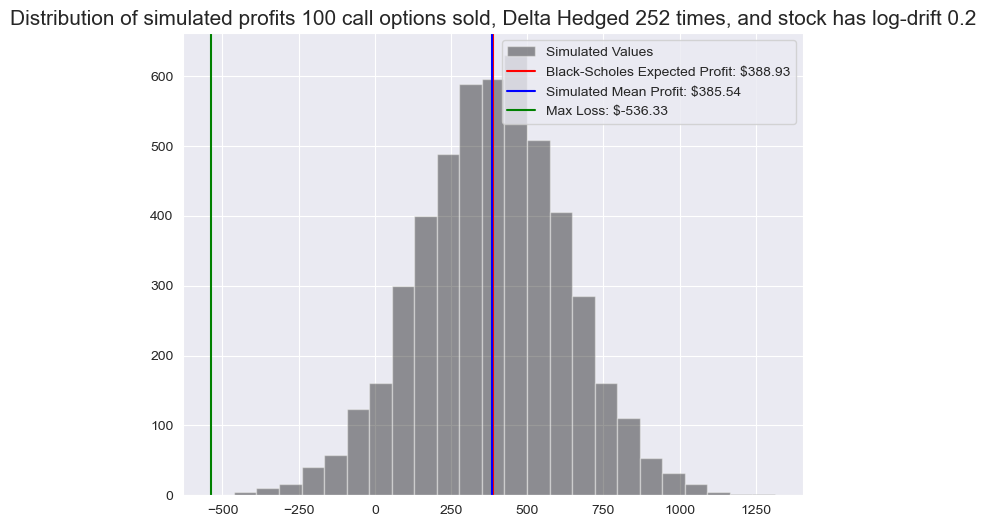

Simulated-Black Scholes Price: $385.54  with 5000 simulations and 252 control variants    standard error: 3.412319


()

In [164]:
sigma_array = [0.4]
sigma_probs = [1.0]

plot_PL_dist(sigma_array,sigma_probs)


As a next step, I have used a custom model with an average volatility that is equal to the constant volatility examined in the previous case.
This helps us isolate the effets of changing volatility, without any bias.

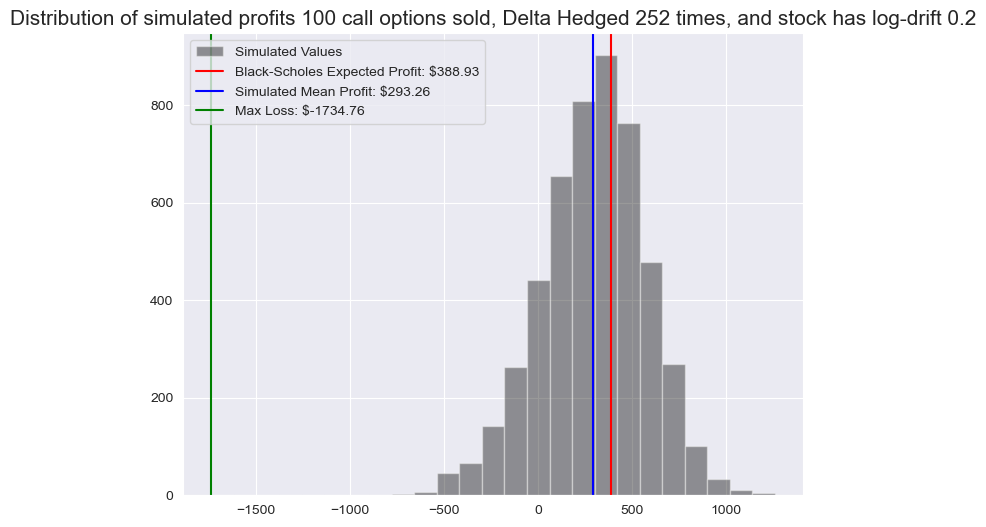

Simulated-Black Scholes Price: $293.26  with 5000 simulations and 252 control variants    standard error: 3.944693


()

In [165]:
sigma_array = [0.4, 0.2, 0.6]
sigma_probs = [0.5, 0.25,0.25]

plot_PL_dist(sigma_array,sigma_probs)

We notice that while the Black-Scholes expected profit is same, the distribution now shifts left and also has a higher skew towards more losses. This can also be seen in the increased amount of maximum loss. There is a much higher probability of losses around 500, compared to the previous case. The mean has also shifted left.

Conclusion: Increasing volatility both shifts the distribution towards less profit and and skews the distribution towards more extreme losses.

### Hedging

To hedge against non-constant volatility, it is not possible to use only stocks. We would have to add other options of the same underlying to achieve the hedge. The sensitivity of the option price to volatility is captured by the Greek vega. The crucial fact is that vega of the option price is different for different expiry dates and for different strike prices. So, it is possible to hold positions of options of different (1) expiry date  or (2) strike prices to achieve a vega-neutral position which stays neutral to any movements in volitility. 

Simplifying assumption: 

* To avoid complications arising from options used to hedge expiring within a year, I will focus only on using an option with a different strike price with same expiry date to hedge.  Let the option being sold be called option A (we are short on this) and the option bought be called option B (we are long on this). Option B has a strike price of 120 but same expiry date.
* I have used the Black Scholes Greek vega with average volatility as the simplest approximation for vega instead of simulating vega for the custom model. Let vega_A and vega_B are the vegas of the two options 
* Delta hedging is for the two options are not explicitly modeled but implicitly carried out in the MC_call_custom_sigma option for both.
* I have only hedged with option B at the beginning of the period. Ideally, we could implement a dynamic hedging protocol for this too.
* For now: I am ignoring the capital requirements to pay the premium (because, it needs further considerations on how much premium would be charged for option B etc). Therefore, the profits numbers are going to be offset by a large number. But as the premium is going to be a fixed number, this only causes a shift of mean and does not affect the variance of the distribution, which is what we are interested in.

Let the amount of option B we need to purchase be $\lambda$. We get this by imposing a vega neutral condition
$-\nu_A + \lambda \nu_B = 0$

In [166]:
sigma_avg = np.array(sigma_array).dot(np.array(sigma_probs))
premium = bs_call(S0,K,sigma_avg + .1, t, r)
vega_A = bs_vega(S0,K,sigma_avg,t,r)
vega_B = bs_vega(S0,K+20,sigma_avg,t,r)
lamda = vega_A/vega_B
print(lamda)




1.0127990309225665


In [167]:
premium = bs_call(S0,K,sigma_avg + .1, t, r)
bs_price_short = bs_call(S0,K,sigma_avg,t,r)
bs_price_long = bs_call(S0,K+20,sigma_avg,t,r)
sold_calls_hedged = MC_call_custom_sigma(S0, K, sigma_array,sigma_probs, t, r, mu, n_sims, n_hedges, delta_sims)
long_calls_profit = MC_call_custom_sigma(S0, K+20, sigma_array, sigma_probs,t,r, mu,n_sims,n_hedges,delta_sims)
profits_hedged = num_options*(premium - sold_calls_hedged + lamda*(long_calls_profit))



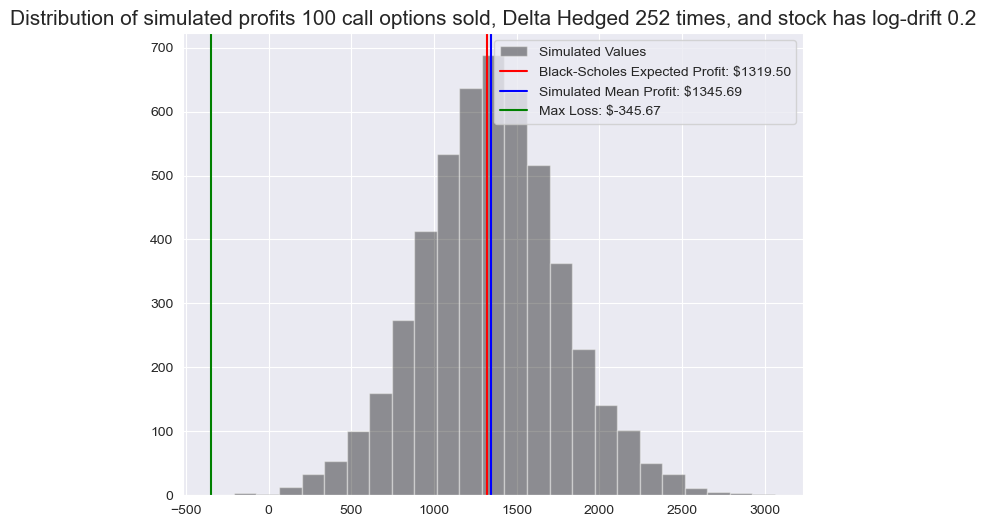

Simulated-Black Scholes Price: $1345.69  with 5000 simulations and 252 control variants standard error: 5.990148


In [168]:
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(num_options*(premium - bs_price_short + lamda*(bs_price_long)), label = f'Black-Scholes Expected Profit: ${num_options*(premium - bs_price_short + lamda*(bs_price_long)):.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged {n_hedges} times, and stock has log-drift {mu}',size = 15)
plt.show()

std_err = np.std(profits_hedged)/np.sqrt(n_sims)
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations and {n_hedges} control variants standard error: {std_err:.6f}')

**Conclusion: Maxium loss is reduced compared to the unhedged case**